## Utils

In [3]:
import requests
from bs4 import BeautifulSoup
import json


In [4]:
def build_file_name(url):
    return 'raw_documents/'+'-'.join(url.split("/")[2:]).replace('.','-') + ".json"

In [5]:
def find_title(soup):
    for tag in ['h1', 'h2', 'h3', 'h4', 'h5', 'h6']:
        title_tag = soup.find(tag)
        if title_tag:
            return title_tag.get_text(strip=True)
    return -1  # Default title if no header tags found

In [27]:
def parse_content_with_hierarchy0(soup):
    data = {}
    current_h1 = current_h2 = current_h3 = current_h4 = current_h5 = current_h6 = None

    # Define block-level tags to process
    block_tags = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'p', 'div', 'li']

    # Iterate over block-level headings and paragraphs
    for tag in soup.find_all(block_tags):
        text = tag.get_text(strip=True)

        if tag.name == 'div' and tag.get('class') and 'crt-post-text' in tag.get('class'):
            if current_h6:
                data[current_h1][current_h2][current_h3][current_h4][current_h5][current_h6].setdefault('content', []).append(text)
            elif current_h5:
                data[current_h1][current_h2][current_h3][current_h4][current_h5].setdefault('content', []).append(text)
            elif current_h4:
                data[current_h1][current_h2][current_h3][current_h4].setdefault('content', []).append(text)
            elif current_h3:
                data[current_h1][current_h2][current_h3].setdefault('content', []).append(text)
            elif current_h2:
                data[current_h1][current_h2].setdefault('content', []).append(text)
        elif tag.name == 'div':
            continue
        elif tag.name == 'h1':
            current_h1 = text
            data[current_h1] = {}
            current_h2 = current_h3 = current_h4 = current_h5 = current_h6 = None
        elif tag.name == 'h2' and current_h1:
            current_h2 = text
            data[current_h1][current_h2] = {}
            current_h3 = current_h4 = current_h5 = current_h6 = None
        elif tag.name == 'h3' and current_h2:
            current_h3 = text
            data[current_h1][current_h2][current_h3] = {}
            current_h4 = current_h5 = current_h6 = None
        elif tag.name == 'h4' and current_h3:
            current_h4 = text
            data[current_h1][current_h2][current_h3][current_h4] = {}
            current_h5 = current_h6 = None
        elif tag.name == 'h5' and current_h4:
            current_h5 = text
            data[current_h1][current_h2][current_h3][current_h4][current_h5] = {}
            current_h6 = None
        elif tag.name == 'h6' and current_h5:
            current_h6 = text
            data[current_h1][current_h2][current_h3][current_h4][current_h5][current_h6] = {}
        else:
            if current_h6:
                data[current_h1][current_h2][current_h3][current_h4][current_h5][current_h6].setdefault('content', []).append(text)
            elif current_h5:
                data[current_h1][current_h2][current_h3][current_h4][current_h5].setdefault('content', []).append(text)
            elif current_h4:
                data[current_h1][current_h2][current_h3][current_h4].setdefault('content', []).append(text)
            elif current_h3:
                data[current_h1][current_h2][current_h3].setdefault('content', []).append(text)
            elif current_h2:
                data[current_h1][current_h2].setdefault('content', []).append(text)
            elif current_h1:
                data[current_h1].setdefault('content', []).append(text)
            else:
                data.setdefault('content', []).append(text)

    front_head = (current_h1 or current_h2 or current_h3 or 
                 current_h4 or current_h5 or current_h6 or None)
    print(data)
    return data, front_head

In [19]:
def parse_content_with_hierarchy(soup):
    data = {}
    headings = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6']
    current_headings = {level: None for level in headings}

    def set_default(level):
        """为当前缺失的上一级标题设置默认值"""
        for h in headings[:headings.index(level)]:
            if current_headings[h] is None:
                current_headings[h] = f'Default {h.upper()}'
                if h == 'h1':
                    data[current_headings['h1']] = {}
                else:
                    parent = data[current_headings['h1']]
                    for upper in headings[1:headings.index(h)]:
                        parent = parent[current_headings[upper]]
                    parent[current_headings[h]] = {}

    for tag in soup.find_all(headings + ['p']):
        if tag.name in headings:
            set_default(tag.name)  # 如果需要，为上级标题设定默认值
            current_headings[tag.name] = tag.get_text(strip=True)

            # 将新标题加入正确的层级
            if tag.name == 'h1':
                data[current_headings['h1']] = {}
            else:
                parent = data[current_headings['h1']]
                for h in headings[1:headings.index(tag.name)]:
                    parent = parent[current_headings[h]]
                parent[current_headings[tag.name]] = {}
        
        elif tag.name == 'p':
            set_default('h1')  # 确保至少有一个 h1
            parent = data[current_headings['h1']]
            for h in headings[1:]:
                if current_headings[h] is not None:
                    parent = parent[current_headings[h]]
                else:
                    break
            parent.setdefault('content', []).append(tag.get_text(strip=True))

    return data

## Wikipedia

In [32]:
import requests
from bs4 import BeautifulSoup
import json

def scrape_wikipedia_to_json(url, output_file):
    # Send request to the URL
    response = requests.get(url)
    
    # Parse the page content
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the correct div based on the updated structure
    content = soup.find('div', {'id': 'mw-content-text'})

    # Dictionary to store the result
    data = {}
    current_h1 = None
    current_h2 = None
    current_h3 = None
    current_h4 = None
    current_h5 = None
    current_h6 = None

    # Iterate over headings and paragraphs
    for tag in content.find_all(['h2', 'h3', 'h4', 'h5', 'h6', 'p']):
        if tag.name == 'h2':
            current_h2 = tag.get_text(strip=True)
            data[current_h2] = {}
            current_h3 = current_h4 = current_h5 = current_h6 = None
        elif tag.name == 'h3' and current_h2:
            current_h3 = tag.get_text(strip=True)
            data[current_h2][current_h3] = {}
            current_h4 = current_h5 = current_h6 = None
        elif tag.name == 'h4' and current_h3:
            current_h4 = tag.get_text(strip=True)
            data[current_h2][current_h3][current_h4] = {}
            current_h5 = current_h6 = None
        elif tag.name == 'h5' and current_h4:
            current_h5 = tag.get_text(strip=True)
            data[current_h2][current_h3][current_h4][current_h5] = {}
            current_h6 = None
        elif tag.name == 'h6' and current_h5:
            current_h6 = tag.get_text(strip=True)
            data[current_h2][current_h3][current_h4][current_h5][current_h6] = {}
        elif tag.name == 'p':
            if current_h6:
                data[current_h2][current_h3][current_h4][current_h5][current_h6].setdefault('content', []).append(tag.get_text())
            elif current_h5:
                data[current_h2][current_h3][current_h4][current_h5].setdefault('content', []).append(tag.get_text())
            elif current_h4:
                data[current_h2][current_h3][current_h4].setdefault('content', []).append(tag.get_text())
            elif current_h3:
                data[current_h2][current_h3].setdefault('content', []).append(tag.get_text())
            elif current_h2:
                data[current_h2].setdefault('content', []).append(tag.get_text())
            else:
                data.setdefault('content', []).append(tag.get_text())
    
    # Save the dictionary as a JSON file
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
    
    print(f"Content successfully written to {output_file}")


In [28]:

 def find_history_links(soup, url):
     # Find the <h2> tag with id='History'
    history_section = soup.find('div', class_ = 'mw-heading mw-heading2')
    
    if not history_section:
        print("No 'History' section found.")
        return
    
    # Find all the tags after the <h2 id='History'> tag
    links = []
    next_tag = history_section.find_next_sibling()
    print('next tag', next_tag)
    
    # Loop through the following sibling tags until we reach the end or another <h2> tag
    while next_tag and not (next_tag.name == 'div' and set(['mw-heading', 'mw-heading2']).issubset(next_tag.get('class', []))):
        # Find all <a> tags in the current tag
        for link in next_tag.find_all('a', href=True):
            links.append(urljoin(url, link['href']))
        # Move to the next sibling
        next_tag = next_tag.find_next_sibling()
        print('next tag', next_tag)

    return links
    

# Function to extract links and their content from a specific module (reading-channel)
def crawl_page_weki(url, output_file):
    # Send a request to the webpage
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to retrieve {url}")
        return

    # Parse the page content with BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract only the 'reading-channel' module
    module = soup.find('div', {'id': 'mw-content-text'})
    if not module:
        print("No 'reading-channel' module found.")
        return

    # Find all hyperlinks in the 'reading-channel' module
    links = find_history_links(module, url)
    print(links)
    # Dictionary to store content with titles
    content_dict = {}
    title = find_title(soup)
    content_dict[title], _ = parse_content_with_hierarchy0(module)

    
    # Crawl each hyperlink (depth = 1)
    for link in links:
        link_url = link
        
        try:
            # Send a request to the hyperlink
            link_response = requests.get(link_url)
            if link_response.status_code == 200:
                link_soup = BeautifulSoup(link_response.content, 'html.parser')
                
                # Find the title by checking h1, h2, h3, etc.
                title = find_title(link_soup)
                if title == -1:
                    title = link_url

                if link_url.startswith("https://en.wikipedia.org/wiki/"):
                    # Only extract 'reading-channel' content from Britannica links
                    new_module = link_soup.find('div', {'id': 'mw-content-text'})
                    if new_module:
                        content_dict[title], _ = parse_content_with_hierarchy0(new_module)
                    else:
                        print(f"No 'reading-channel' module found in {link_url}")
                        continue
                else:
                    # Otherwise, extract the entire page content
                    content_dict[title], _ = parse_content_with_hierarchy0(link_soup)
        except Exception as e:
            print(f"Failed to retrieve content from {link_url}: {e}")
    
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(content_dict, f, ensure_ascii=False, indent=4)
    print(f"Content successfully written to {output_file}")


In [29]:
crawl_page_weki("https://en.wikipedia.org/wiki/Pittsburgh","Pittsburgh_Wikipedia.json")

next tag <link href="mw-data:TemplateStyles:r1236090951" rel="mw-deduplicated-inline-style"/>
next tag <div class="hatnote navigation-not-searchable" role="note">Main article: <a href="/wiki/Name_of_Pittsburgh" title="Name of Pittsburgh">Name of Pittsburgh</a></div>
next tag <p>Pittsburgh was named in 1758, by General <a href="/wiki/John_Forbes_(British_Army_officer)" title="John Forbes (British Army officer)">John Forbes</a>, in honor of British statesman <a href="/wiki/William_Pitt,_1st_Earl_of_Chatham" title="William Pitt, 1st Earl of Chatham">William Pitt, 1st Earl of Chatham</a>. As Forbes was a <a href="/wiki/Scottish_people" title="Scottish people">Scotsman</a>, he probably pronounced the name <span class="rt-commentedText nowrap"><span class="IPA nopopups noexcerpt" lang="en-fonipa"><a href="/wiki/Help:IPA/English" title="Help:IPA/English">/<span style="border-bottom:1px dotted"><span title="/ˈ/: primary stress follows">ˈ</span><span title="'p' in 'pie'">p</span><span title="/ɪ

In [34]:
url_list = ["https://en.wikipedia.org/wiki/Pittsburgh", "https://en.wikipedia.org/wiki/History_of_Pittsburgh",
"https://en.wikipedia.org/wiki/Carnegie_Mellon_University"]
history_list = ['https://en.wikipedia.org/wiki/Name_of_Pittsburgh', 'https://en.wikipedia.org/wiki/John_Forbes_(British_Army_officer)', 'https://en.wikipedia.org/wiki/William_Pitt,_1st_Earl_of_Chatham', 'https://en.wikipedia.org/wiki/Scottish_people', 'https://en.wikipedia.org/wiki/Help:IPA/English', 'https://en.wikipedia.org/wiki/Help:Pronunciation_respelling_key', 'https://en.wikipedia.org/wiki/Edinburgh', 'https://en.wikipedia.org/wiki/Pittsburgh#cite_note-spell-18', 'https://en.wikipedia.org/wiki/Pittsburgh#cite_note-19', 'https://en.wikipedia.org/wiki/Borough_(Pennsylvania)', 'https://en.wikipedia.org/wiki/Pittsburgh#cite_note-20', 'https://en.wikipedia.org/wiki/Pennsylvania_State_Senate', 'https://en.wikipedia.org/wiki/Pennsylvania_House_of_Representatives', 'https://en.wikipedia.org/wiki/Pittsburgh#cite_note-21', 'https://en.wikipedia.org/wiki/Pittsburgh#cite_note-22', 'https://en.wikipedia.org/wiki/Pittsburgh#cite_note-spell-18', 'https://en.wikipedia.org/wiki/Pittsburgh#cite_note-spell-18', 'https://en.wikipedia.org/wiki/The_Pittsburgh_Press', 'https://en.wikipedia.org/wiki/Pittsburgh#cite_note-23']
url_list.extend(history_list)
output_file_list = ['/Users/yaqi/Codespace/RAGinBurgh/data_collect/raw_documents/General_Info_History/'+url.split('/')[-1]+'.json' for url in url_list]
for url, output_file in zip(url_list, output_file_list):
    scrape_wikipedia_to_json(url, output_file)

Content successfully written to /Users/yaqi/Codespace/RAGinBurgh/data_collect/raw_documents/General_Info_History/Pittsburgh.json
Content successfully written to /Users/yaqi/Codespace/RAGinBurgh/data_collect/raw_documents/General_Info_History/History_of_Pittsburgh.json
Content successfully written to /Users/yaqi/Codespace/RAGinBurgh/data_collect/raw_documents/General_Info_History/Carnegie_Mellon_University.json
Content successfully written to /Users/yaqi/Codespace/RAGinBurgh/data_collect/raw_documents/General_Info_History/Name_of_Pittsburgh.json
Content successfully written to /Users/yaqi/Codespace/RAGinBurgh/data_collect/raw_documents/General_Info_History/John_Forbes_(British_Army_officer).json
Content successfully written to /Users/yaqi/Codespace/RAGinBurgh/data_collect/raw_documents/General_Info_History/William_Pitt,_1st_Earl_of_Chatham.json
Content successfully written to /Users/yaqi/Codespace/RAGinBurgh/data_collect/raw_documents/General_Info_History/Scottish_people.json
Content su

In [35]:
url_list = ['https://en.wikipedia.org/wiki/List_of_people_from_Pittsburgh']
output_file_list = ['/Users/yaqi/Codespace/RAGinBurgh/data_collect/raw_documents/General_Info_History/'+url.split('/')[-1]+'.json' for url in url_list]
for url, output_file in zip(url_list, output_file_list):
    scrape_wikipedia_to_json(url, output_file)

Content successfully written to /Users/yaqi/Codespace/RAGinBurgh/data_collect/raw_documents/General_Info_History/List_of_people_from_Pittsburgh.json


table 

In [3]:
import requests
from bs4 import BeautifulSoup
import csv

# Function to scrape all tables from a Wikipedia page and save each to a separate CSV
def scrape_all_tables_to_csv(url):
    # Send request to the URL
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to retrieve {url}")
        return

    # Parse the HTML content
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find all tables in the page
    tables = soup.find_all('table', {'class': 'wikitable'})  # Wikipedia tables usually have 'wikitable' class

    # Check how many tables were found
    print(f"Found {len(tables)} tables.")
    
    # Iterate through each table and save to a CSV
    for i, table in enumerate(tables):
        # Extract rows from the table
        rows = table.find_all('tr')
        
        # Extract data from each row
        table_data = []
        for row in rows:
            # Extract header cells (th) or regular cells (td)
            cols = row.find_all(['th', 'td'])
            cols = [col.get_text(strip=True) for col in cols]  # Clean the cell content by stripping extra spaces
            table_data.append(cols)
        
        # Create a CSV filename for each table, e.g., "table_1.csv", "table_2.csv", etc.
        csv_filename = f"table_{i+1}.csv"
        
        # Save the table data to a CSV file
        with open(csv_filename, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerows(table_data)
        
        # Print a message to confirm the table has been saved
        print(f"Table {i+1} saved to {csv_filename}")

# Example usage
url = "https://en.wikipedia.org/wiki/Pittsburgh"
scrape_all_tables_to_csv(url)

Found 8 tables.
Table 1 saved to table_1.csv
Table 2 saved to table_2.csv
Table 3 saved to table_3.csv
Table 4 saved to table_4.csv
Table 5 saved to table_5.csv
Table 6 saved to table_6.csv
Table 7 saved to table_7.csv
Table 8 saved to table_8.csv


In [4]:
# Example usage
url = "https://en.wikipedia.org/wiki/History_of_Pittsburgh"
scrape_all_tables_to_csv(url)

Found 4 tables.
Table 1 saved to table_1.csv
Table 2 saved to table_2.csv
Table 3 saved to table_3.csv
Table 4 saved to table_4.csv


#### ---- scripts

In [45]:
type(content)

bs4.element.Tag

In [56]:
content = soup.find('div', {'id': 'bodyContent'})

In [ ]:
content

In [ ]:
for tag in content.find_all(['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'p']):
    print(tag.name)

In [60]:
# Dictionary to store the result
data = {}
current_h1 = None
current_h2 = None
current_h3 = None
current_h4 = None
current_h5 = None
current_h6 = None

# Iterate over headings and paragraphs
for tag in content.find_all(['h2', 'h3', 'h4', 'h5', 'h6', 'p']):
    if tag.name == 'h2':
        current_h2 = tag.get_text(strip=True)
        data[current_h2] = {}
        current_h3 = current_h4 = current_h5 = current_h6 = None
    elif tag.name == 'h3' and current_h2:
        current_h3 = tag.get_text(strip=True)
        data[current_h2][current_h3] = {}
        current_h4 = current_h5 = current_h6 = None
    elif tag.name == 'h4' and current_h3:
        current_h4 = tag.get_text(strip=True)
        data[current_h2][current_h3][current_h4] = {}
        current_h5 = current_h6 = None
    elif tag.name == 'h5' and current_h4:
        current_h5 = tag.get_text(strip=True)
        data[current_h2][current_h3][current_h4][current_h5] = {}
        current_h6 = None
    elif tag.name == 'h6' and current_h5:
        current_h6 = tag.get_text(strip=True)
        data[current_h2][current_h3][current_h4][current_h5][current_h6] = {}
    elif tag.name == 'p':
        if current_h6:
            data[current_h2][current_h3][current_h4][current_h5][current_h6].setdefault('content', []).append(tag.get_text(strip=True))
        elif current_h5:
            data[current_h2][current_h3][current_h4][current_h5].setdefault('content', []).append(tag.get_text(strip=True))
        elif current_h4:
            data[current_h2][current_h3][current_h4].setdefault('content', []).append(tag.get_text(strip=True))
        elif current_h3:
            data[current_h2][current_h3].setdefault('content', []).append(tag.get_text(strip=True))
        elif current_h2:
            data[current_h2].setdefault('content', []).append(tag.get_text(strip=True))

In [ ]:
data

## pittsburghpa.gov

### get subpages' url

In [ ]:
import requests
from bs4 import BeautifulSoup

def get_subpage_links(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find all <a> tags
    links = []
    for a_tag in soup.find_all('a', href=True):
        link = a_tag['href']
        if link.startswith('/'):  # If it's a relative link, prepend the base URL
            link = f"{url.rstrip('/')}{link}"
        links.append(link)
    
    return links

# # Example usage
# url = "https://pittsburghpa.gov/index.html"  # Replace with the base URL
# subpage_links = get_subpage_links(url)
# print(f"Found {len(subpage_links)} subpage links:")
# for link in subpage_links:
#     print(link)

In [8]:
response = requests.get('https://pittsburghpa.gov/finance/tax-forms')
soup = BeautifulSoup(response.content, 'html.parser')

div = soup.find('div', class_='opened-for-codepen')

gov_finance_urls = []
if div:
    links = div.find_all('a')
    for link in links:
        gov_finance_urls.append(link['href'])
else:
    print("未找到class='opened-for-codepen'的div标签")

In [12]:
import requests
from bs4 import BeautifulSoup

response = requests.get('https://pittsburghpa.gov/events/index.html')
soup = BeautifulSoup(response.content, 'html.parser')
soup_ = soup.find('div', class_ = 'col-sm-3')
div = soup_.find('div', class_ = 'accordion')

gov_events_urls = []
if div:
    links = div.find_all('a')
    for link in links:
        gov_events_urls.append(link['href'])

gov_events_urls


['https://apps.pittsburghpa.gov/redtail/images/25073_SummerGuide-2024-WEB.pdf',
 'https://pittsburghpa.gov/events/black-history',
 'https://pittsburghpa.gov/events/cinema',
 'https://pittsburghpa.gov/events/cinema',
 'https://pittsburghpa.gov/events/arsenal',
 'https://pittsburghpa.gov/events/banksville',
 'https://pittsburghpa.gov/events/brookline',
 'https://pittsburghpa.gov/events/schenley',
 'https://pittsburghpa.gov/events/grandview',
 'https://pittsburghpa.gov/events/highland',
 'https://pittsburghpa.gov/events/mcbride',
 'https://pittsburghpa.gov/events/ormsby',
 'https://pittsburghpa.gov/events/cinema-riverview',
 'https://pittsburghpa.gov/events/schenley-plaza',
 'https://pittsburghpa.gov/events/west-end',
 'https://pittsburghpa.gov/events/community-festivals',
 'https://pittsburghpa.gov/events/concerts',
 'https://pittsburghpa.gov/events/bach-beethoven-brunch',
 'https://pittsburghpa.gov/events/jam-at-grandview',
 'https://pittsburghpa.gov/events/reservoir-jazz',
 'https://pi

In [11]:
response = requests.get('https://pittsburghpa.gov/city-info/policies')
soup = BeautifulSoup(response.content, 'html.parser')
div = soup.find('div', class_ = 'accordion')

gov_policy_urls = []
if div:
    links = div.find_all('a')
    for link in links:
        gov_policy_urls.append(link['href'])
gov_policy_urls

['https://pittsburghpa.gov/city-info/press-releases',
 'https://pittsburghpa.gov/city-info/socialmedia',
 'https://pittsburghpa.gov/city-info/frequent-numbers',
 'https://pittsburghpa.gov/city-info/executive-orders',
 'https://pittsburghpa.gov/city-info/policies']

### build documents

In [24]:
import requests
from bs4 import BeautifulSoup
import json

def scrape_gov_to_json(url, output_file):
    # Send request to the URL
    response = requests.get(url)
    
    # Parse the page content
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the correct div based on the updated structure
    content = soup.find('div', {'class': 'col-md-12'})

    # Dictionary to store the result
    data = {}
    for passage in content.find_all('p'):
        data.setdefault('content', []).append(passage.get_text(strip=True))
    
    # Save the dictionary as a JSON file
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
    
    print(f"Content successfully written to {output_file}")

def gov_url_list_to_docuemnts(url_list):
    for url in url_list:
        if url.endswith('pdf'):
            print(f"Skipping PDF file: {url}")
            continue
        try:
            output_file = build_file_name(url)
            scrape_gov_to_json(url, output_file)
        except Exception as e:
            print(f"Failed to scrape {url}: {e}")
            continue


In [ ]:
# https://pittsburghpa.gov/pittsburgh/pgh-about
gov_urls = ["https://pittsburghpa.gov/pittsburgh/pgh-about", "https://pittsburghpa.gov/pittsburgh/pgh-sports", 
"https://pittsburghpa.gov/pittsburgh/cultural-activities", "https://pittsburghpa.gov/pittsburgh/flag-seal", 
"https://pittsburghpa.gov/mayor/pghmayors"]

gov_url_list_to_docuemnts(gov_urls)

In [ ]:
gov_url_list_to_docuemnts(gov_finance_urls)

In [ ]:
gov_url_list_to_docuemnts(gov_events_urls)

In [41]:
gov_url_list_to_docuemnts(gov_policy_urls)

Content successfully written to raw_documents/pittsburghpa-gov-city-info-press-releases.json
Content successfully written to raw_documents/pittsburghpa-gov-city-info-socialmedia.json
Content successfully written to raw_documents/pittsburghpa-gov-city-info-frequent-numbers.json
Content successfully written to raw_documents/pittsburghpa-gov-city-info-executive-orders.json
Content successfully written to raw_documents/pittsburghpa-gov-city-info-policies.json


### process json files

In [5]:
import os
import json

def process_json_files(folder_path):
    """
    This function takes the path of a folder, processes all json files within that folder
    that follow the '-events' naming pattern, and merges their 'content' into a single 
    dictionary based on the event name.
    
    Parameters:
    folder_path (str): The path of the folder containing json files.
    
    Returns:
    dict: A dictionary with event names as keys and corresponding 'content' as values.
    """
    gov_events = {}

    # Iterate over all files in the given folder
    for file_name in os.listdir(folder_path):
        # Check if the file ends with "-events.json"
        if file_name.startswith("pittsburghpa-gov") and file_name.endswith(".json"):
            event_key = file_name.replace("pittsburghpa-gov", "").replace(".json", "")
            file_path = os.path.join(folder_path, file_name)

            # Read the content of the json file
            with open(file_path, "r", encoding="utf-8") as json_file:
                data = json.load(json_file)
                content_list = data.get("content", [])
                filtered_content = [line for line in content_list if line.strip()]  # Skip empty strings
                gov_events[event_key] = filtered_content
    
    return gov_events

folder_path = '/Users/yaqi/Codespace/RAGinBurgh/data_collect/raw_documents'
result = process_json_files(folder_path)
output_path = os.path.join(folder_path, "gov-info.json")
with open(output_path, "w", encoding="utf-8") as output_file:
    json.dump(result, output_file, ensure_ascii=False,indent=4)

output_path

'/Users/yaqi/Codespace/RAGinBurgh/data_collect/raw_documents/gov-events.json'

### pdf

In [31]:
import requests
import pdfplumber

# 1. 通过 URL 下载 PDF
def download_pdf(url, output_path):
    response = requests.get(url)
    with open(output_path, 'wb') as file:
        file.write(response.content)

# 2. 将 PDF 转换为文字
def pdf_to_text(pdf_path):
    text = ''
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            print(page)
            text += page.extract_text()
    return text

# 示例使用
url = "https://apps.pittsburghpa.gov/redtail/images/25073_SummerGuide-2024-WEB.pdf"
pdf_path = "raw_documents/gov_summer_event_guide.pdf"

# 下载 PDF
download_pdf(url, pdf_path)

# PDF 转文字
pdf_text = pdf_to_text(pdf_path)
print(pdf_text)

<Page:1>
<Page:2>
<Page:3>
<Page:4>
<Page:5>
<Page:6>
<Page:7>
<Page:8>



In [37]:
pip install pymupdf

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 18.2 MB 2.5 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [38]:
import fitz  # PyMuPDF

def pdf_to_text_pymupdf(pdf_path):
    text = ''
    pdf_document = fitz.open(pdf_path)
    for page_num in range(pdf_document.page_count):
        page = pdf_document.load_page(page_num)
        text += page.get_text("text")  # 使用 "text" 模式提取纯文本
    return text

pdf_text = pdf_to_text_pymupdf(pdf_path)
print(pdf_text)

## britannica.com/place/Pittsburgh

In [47]:
# https://www.britannica.com/place/Pittsburgh

response = requests.get('https://www.britannica.com/place/Pittsburgh')
soup = BeautifulSoup(response.content, 'html.parser')
content = soup.find('div', class_ = 'reading-channel')

data = {}
for passage in content.find_all('p'):
    data.setdefault('content', []).append(passage.get_text(strip=True))

with open('raw_documents/Pittsburgh_Britannica.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)


In [13]:
# Function to extract the title by searching h1, h2, h3, etc.
def find_title(soup):
    for tag in ['h1', 'h2', 'h3', 'h4', 'h5', 'h6']:
        title_tag = soup.find(tag)
        if title_tag:
            return title_tag.get_text(strip=True)
    return -1  # Default title if no header tags found


# Function to extract links and their content from a specific module (reading-channel)
def crawl_page(url):
    # Send a request to the webpage
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to retrieve {url}")
        return

    # Parse the page content with BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract only the 'reading-channel' module
    module = soup.find('div', class_='reading-channel')
    if not module:
        print("No 'reading-channel' module found.")
        return

    # Find all hyperlinks in the 'reading-channel' module
    links = module.find_all('a', href=True)
    
    # Dictionary to store content with titles
    content_dict = {}
    
    # Crawl each hyperlink (depth = 1)
    for link in links:
        link_url = urljoin(url, link['href'])
        
        try:
            # Send a request to the hyperlink
            link_response = requests.get(link_url)
            if link_response.status_code == 200:
                link_soup = BeautifulSoup(link_response.content, 'html.parser')
                
                # Find the title by checking h1, h2, h3, etc.
                title = find_title(link_soup)
                if title == -1:
                    title = link_url
                
                # Check if the new URL starts with 'https://www.britannica.com/'
                if link_url.startswith("https://www.britannica.com/news"):
                    new_module = link_soup.find('div', class_ = 'col-sm mendel-content-rail')
                    if new_module:
                        content_dict[title] = parse_content_with_hierarchy(new_module)
                    else:
                        print(f"No 'col-sm mendel-content-rail' module found in {link_url}")
                elif link_url.startswith("https://www.britannica.com/"):
                    # Only extract 'reading-channel' content from Britannica links
                    new_module = link_soup.find('div', class_='reading-channel')
                    if new_module:
                        content_dict[title] = parse_content_with_hierarchy(new_module)
                    else:
                        print(f"No 'reading-channel' module found in {link_url}")
                        continue
                else:
                    # Otherwise, extract the entire page content
                    content_dict[title] = parse_content_with_hierarchy(new_module)
        except Exception as e:
            print(f"Failed to retrieve content from {link_url}: {e}")
    
    return content_dict

In [18]:
# Example usage
url = "https://www.britannica.com/place/Pittsburgh"
crawled_data = crawl_page(url)
crawled_data

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Failed to retrieve content from https://cdn.britannica.com/74/65574-050-B1A02E0C/Downtown-Pittsburgh-Pennsylvania-Fort-Pitt-Bridge-Monongahela.jpg: local variable 'new_module' referenced before assignment
Failed to retrieve content from https://cdn.britannica.com/74/65574-050-B1A02E0C/Downtown-Pittsburgh-Pennsylvania-Fort-Pitt-Bridge-Monongahela.jpg: local variable 'new_module' referenced before assignment
Failed to retrieve content from https://www.facebook.com/BRITANNICA/: local variable 'new_module' referenced before assignment
Failed to retrieve content from https://x.com/britannica: local variable 'new_module' referenced before assignment
No 'reading-channel' module found in https://www.britannica.com/editor/The-Editors-of-Encyclopaedia-Britannica/4419
No 'reading-channel' module found in https://www.britannica.com/place/Pittsburgh/additional-info#history
No 'reading-channel' module found in https://www.britannica.com/place/Golden-Triangle-region-Pittsburgh-Pennsylvania
No 'readin

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


No 'reading-channel' module found in https://www.britannica.com/dictionary/vital
No 'reading-channel' module found in https://www.britannica.com/money/Andrew-Carnegie
No 'reading-channel' module found in https://www.britannica.com/money/Henry-Clay-Frick


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


No 'reading-channel' module found in https://www.britannica.com/dictionary/crested
No 'reading-channel' module found in https://www.britannica.com/money/unemployment
Failed to retrieve content from https://www.merriam-webster.com/dictionary/notorious: 'NoneType' object has no attribute 'find_all'


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


No 'reading-channel' module found in https://www.britannica.com/money/service-industry
Failed to retrieve content from https://cdn.britannica.com/66/116666-004-218DC454/Student-Union-Duquesne-University-Pittsburgh.jpg: 'NoneType' object has no attribute 'find_all'
Failed to retrieve content from https://cdn.britannica.com/66/116666-004-218DC454/Student-Union-Duquesne-University-Pittsburgh.jpg: 'NoneType' object has no attribute 'find_all'


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


No 'reading-channel' module found in https://www.britannica.com/place/The-Andy-Warhol-Museum
Failed to retrieve content from https://www.merriam-webster.com/dictionary/affiliated: 'NoneType' object has no attribute 'find_all'
No 'reading-channel' module found in https://www.britannica.com/place/Carnegie-Library-of-Pittsburgh
No 'reading-channel' module found in https://www.britannica.com/money/Heinz-Company
Failed to retrieve content from https://www.merriam-webster.com/dictionary/venues: 'NoneType' object has no attribute 'find_all'
No 'reading-channel' module found in https://www.britannica.com/place/PNC-Park
No 'reading-channel' module found in https://www.britannica.com/place/Acrisure-Stadium
No 'reading-channel' module found in https://www.britannica.com/editor/The-Editors-of-Encyclopaedia-Britannica/4419
No 'reading-channel' module found in https://www.britannica.com/editor/Amy-Tikkanen/6393


{'Pittsburgh': {'Pittsburgh': {'content': ['Our editors will review what you’ve submitted and determine whether to revise the article.',
    'Our editors will review what you’ve submitted and determine whether to revise the article.'],
   'News•': {'content': ['Pittsburgh,city, seat (1788) ofAllegheny county, southwesternPennsylvania, U.S. The city is located at theconfluenceof theAlleghenyandMonongahelarivers, which unite at the point of the “Golden Triangle” (the business district) to form theOhio River. A city of hills, parks, and valleys, it is the centre of an urban industrial complex that includes the surrounding cities ofAliquippa(northwest),New Kensington(northeast),McKeesport(southeast), andWashington(southwest) and the borough of Wilkinsburg (east). Inc. borough, 1794; city, 1816. Area city, 58 square miles (150 square km). Pop. (2010) 305,704; Pittsburgh Metro Area, 2,356,285; (2020) 302,971; Pittsburgh Metro Area, 2,370,930.']},
   'History': {'content': ['Algonquian- and I

In [21]:
output_file = "crawled_data.json"
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(crawled_data, f, ensure_ascii=False, indent=4)

## visitPittsburgh

event

In [66]:
# https://www.visitpittsburgh.com/events-festivals/annual-events/
# 从class_='content--primary'中提取subpages
import requests
from bs4 import BeautifulSoup

visit_pitt_event_url = 'https://www.visitpittsburgh.com/events-festivals/annual-events/'
response = requests.get(visit_pitt_event_url)
soup = BeautifulSoup(response.content, 'html.parser')
    
# Find all <a> tags
visit_even_links = []
div = soup.find('main', class_='content--primary')
for a_tag in div.find_all('a', href=True):
    link = a_tag['href']
    if link.startswith('/'):  # If it's a relative link, prepend the base URL
        link = f"{url.rstrip('/')}{link}"
    if len(link.split('/')) > 4:
        visit_even_links.append(link)

In [74]:
def scrape_visit_to_json(url, output_file):
    # Send request to the URL
    response = requests.get(url)
    
    # Parse the page content
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the correct div based on the updated structure
    content = soup.find('main', {'class': 'content--primary'})

    # Dictionary to store the result
    data = {}
    current_h1 = None
    current_h2 = None
    current_h3 = None
    current_h4 = None
    current_h5 = None
    current_h6 = None

    # Iterate over headings and paragraphs
    for tag in content.find_all(['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'p']):
        if tag.name == 'h1':
            current_h1 = tag.get_text(strip=True)
            data[current_h1] = {}
            current_h2 = current_h3 = current_h4 = current_h5 = current_h6 = None
        elif tag.name == 'h2' and current_h1:
            current_h2 = tag.get_text(strip=True)
            data[current_h1][current_h2] = {}
            current_h3 = current_h4 = current_h5 = current_h6 = None
        elif tag.name == 'h3' and current_h2:
            current_h3 = tag.get_text(strip=True)
            data[current_h1][current_h2][current_h3] = {}
            current_h4 = current_h5 = current_h6 = None
        elif tag.name == 'h4' and current_h3:
            current_h4 = tag.get_text(strip=True)
            data[current_h1][current_h2][current_h3][current_h4] = {}
            current_h5 = current_h6 = None
        elif tag.name == 'h5' and current_h4:
            current_h5 = tag.get_text(strip=True)
            data[current_h1][current_h2][current_h3][current_h4][current_h5] = {}
            current_h6 = None
        elif tag.name == 'h6' and current_h5:
            current_h6 = tag.get_text(strip=True)
            data[current_h1][current_h2][current_h3][current_h4][current_h5][current_h6] = {}
        elif tag.name == 'p':
            if current_h6:
                data[current_h1][current_h2][current_h3][current_h4][current_h5][current_h6].setdefault('content', []).append(tag.get_text(strip=True))
            elif current_h5:
                data[current_h1][current_h2][current_h3][current_h4][current_h5].setdefault('content', []).append(tag.get_text(strip=True))
            elif current_h4:
                data[current_h1][current_h2][current_h3][current_h4].setdefault('content', []).append(tag.get_text(strip=True))
            elif current_h3:
                data[current_h1][current_h2][current_h3].setdefault('content', []).append(tag.get_text(strip=True))
            elif current_h2:
                data[current_h1][current_h2].setdefault('content', []).append(tag.get_text(strip=True))
            elif current_h1:
                data[current_h1].setdefault('content', []).append(tag.get_text(strip=True))

    
    # Save the dictionary as a JSON file
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
    
    print(f"Content successfully written to {output_file}")

In [75]:
def visit_pitt_event_url_to_docuemnts(url_list):
    for url in url_list:
        if url.endswith('pdf'):
            print(f"Skipping PDF file: {url}")
            continue
        try:
            output_file = build_file_name(url)
            scrape_visit_to_json(url, output_file)
        except Exception as e:
            print(f"Failed to scrape {url}: {e}")
            continue


In [ ]:
visit_pitt_event_url_to_docuemnts(visit_even_links)

sports

In [98]:
visit_pitt_sports_url = 'https://www.visitpittsburgh.com/things-to-do/pittsburgh-sports-teams/'
response = requests.get(visit_pitt_sports_url)
soup = BeautifulSoup(response.content, 'html.parser')
    
# Find all <a> tags
visit_sports_links = []
div = soup.find('main', class_='content--primary')
for a_tag in div.find_all('a', href=True):
    link = a_tag['href']
    if link.startswith('/'):  # If it's a relative link, prepend the base URL
        link = f"{url.rstrip('/')}{link}"
    if len(link.split('/')) > 4:
        visit_sports_links.append(link)

In [99]:
visit_sports_links.extend(['https://www.visitpittsburgh.com/things-to-do/pittsburgh-sports-teams/'])

In [100]:
len(visit_sports_links)

61

In [110]:
def scrape_visit_sport_to_json(url, output_file):
    # Send request to the URL
    response = requests.get(url)
    
    # Parse the page content
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the correct div based on the updated structure
    if 'blog' in url:
        content = soup.find('article',class_= 'detail__inner')
    elif 'directory' in url:
        content = soup.find('div', class_='detail__primary-inner row')
    else:
        content = soup.find('main', {'class': 'content--primary'})

    # Dictionary to store the result
    data = {}
    current_h1 = None
    current_h2 = None
    current_h3 = None
    current_h4 = None
    current_h5 = None
    current_h6 = None

    # Iterate over headings and paragraphs
    for tag in content.find_all(['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'p']):
        if tag.name == 'h1':
            current_h1 = tag.get_text(strip=True)
            data[current_h1] = {}
            current_h2 = current_h3 = current_h4 = current_h5 = current_h6 = None
        elif tag.name == 'h2' and current_h1:
            current_h2 = tag.get_text(strip=True)
            data[current_h1][current_h2] = {}
            current_h3 = current_h4 = current_h5 = current_h6 = None
        elif tag.name == 'h3' and current_h2:
            current_h3 = tag.get_text(strip=True)
            data[current_h1][current_h2][current_h3] = {}
            current_h4 = current_h5 = current_h6 = None
        elif tag.name == 'h4' and current_h3:
            current_h4 = tag.get_text(strip=True)
            data[current_h1][current_h2][current_h3][current_h4] = {}
            current_h5 = current_h6 = None
        elif tag.name == 'h5' and current_h4:
            current_h5 = tag.get_text(strip=True)
            data[current_h1][current_h2][current_h3][current_h4][current_h5] = {}
            current_h6 = None
        elif tag.name == 'h6' and current_h5:
            current_h6 = tag.get_text(strip=True)
            data[current_h1][current_h2][current_h3][current_h4][current_h5][current_h6] = {}
        elif tag.name == 'p':
            if current_h6:
                data[current_h1][current_h2][current_h3][current_h4][current_h5][current_h6].setdefault('content', []).append(tag.get_text(strip=True))
            elif current_h5:
                data[current_h1][current_h2][current_h3][current_h4][current_h5].setdefault('content', []).append(tag.get_text(strip=True))
            elif current_h4:
                data[current_h1][current_h2][current_h3][current_h4].setdefault('content', []).append(tag.get_text(strip=True))
            elif current_h3:
                data[current_h1][current_h2][current_h3].setdefault('content', []).append(tag.get_text(strip=True))
            elif current_h2:
                data[current_h1][current_h2].setdefault('content', []).append(tag.get_text(strip=True))
            elif current_h1:
                data[current_h1].setdefault('content', []).append(tag.get_text(strip=True))

    
    # Save the dictionary as a JSON file
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
    
    print(f"Content successfully written to {output_file}")

def visit_pitt_sport_url_to_docuemnts(url_list):
    for url in url_list:
        if url.endswith('pdf'):
            print(f"Skipping PDF file: {url}")
            continue
        try:
            output_file = build_file_name(url)
            scrape_visit_sport_to_json(url, output_file)
        except Exception as e:
            print(f"Failed to scrape {url}: {e}")
            continue


In [ ]:
visit_pitt_sport_url_to_docuemnts(visit_sports_links)

food

In [103]:
import requests
from bs4 import BeautifulSoup

visit_pitt_food_url = 'https://www.visitpittsburgh.com/restaurants-culinary/'
response = requests.get(visit_pitt_food_url)
soup = BeautifulSoup(response.content, 'html.parser')
    
# Find all <a> tags
visit_food_links = []
div = soup.find('main', class_='content--primary')
for a_tag in div.find_all('a', href=True):
    link = a_tag['href']
    if link.startswith('/'):  # If it's a relative link, prepend the base URL
        link = f"{url.rstrip('/')}{link}"
    if len(link.split('/')) > 4:
        visit_food_links.append(link)

In [ ]:
visit_pitt_sport_url_to_docuemnts(visit_food_links)

In [108]:
# Send request to the URL
url = 'https://www.visitpittsburgh.com/blog/unique-pittsburgh-pierogi-joints/'
response = requests.get(url)

# Parse the page content
soup = BeautifulSoup(response.content, 'html.parser')

# Find the correct div based on the updated structure
if 'blog' in url:
    content = soup.find('article',class_= 'detail__inner')

main pages / other pages

In [113]:
visit_other_url = [
    'https://www.visitpittsburgh.com/',
    'https://www.visitpittsburgh.com/nfl-draft-pittsburgh/',
    'https://www.visitpittsburgh.com/blog/fall-fairs-festivals-and-events/',
    'https://www.visitpittsburgh.com/blog/pittsburgh-fall-date-ideas/',
    'https://www.visitpittsburgh.com/blog/guide-to-football-in-pittsburgh/',
    'https://www.visitpittsburgh.com/blog/upcoming-concerts-in-pittsburgh/',
    'https://www.visitpittsburgh.com/blog/how-to-ride-the-pittsburgh-inclines/',
    'https://www.visitpittsburgh.com/blog/pittsburgh-theatre-upcoming-performances/',
    'https://www.visitpittsburgh.com/blog/penguins-penguins-penguins/',
    'https://www.visitpittsburgh.com/blog/halloween-pop-ups-bars-and-restaurants-in-pittsburgh/',
    'https://www.visitpittsburgh.com/blog/jackworth-ginger-beer-pittsburgh/',
    'https://www.visitpittsburgh.com/restaurants-culinary/farms-farmers-markets/guide-to-pittsburgh-farmers-markets/',
    'https://www.visitpittsburgh.com/restaurants-culinary/farms-farmers-markets/pittsburgh-farm-fresh-meats/',
    'https://www.visitpittsburgh.com/restaurants-culinary/farms-farmers-markets/pittsburghs-csas/',
    'https://www.visitpittsburgh.com/restaurants-culinary/farms-farmers-markets/u-pick-farms/'
]

In [ ]:
visit_pitt_sport_url_to_docuemnts(visit_other_url)

## Gov Tax Forms

参考如何把structure data和RAG结合：https://medium.com/intel-tech/tabular-data-rag-llms-improve-results-through-data-table-prompting-bcb42678914b

In [7]:
from PyPDF2 import PdfReader

def extract_text_from_pdf(pdf_path):
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text()
    return text


In [9]:
# 

import requests
from bs4 import BeautifulSoup
import pandas as pd

# Send HTTP request to fetch the webpage
url = 'https://pittsburghpa.gov/finance/tax-forms'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Find the table containing the forms and their categories
table = soup.find('table')

# Initialize lists to store extracted data
tax_categories = []
links = []
pdf_texts = []

# Loop through each row in the table to extract the category and its associated links
for row in table.find_all('tr'):
    # Extract the tax/fee category from the first column
    category_cell = row.find('td')

    if category_cell:
        category = category_cell.text.strip()  # Get the tax/fee category text
    
        # Extract the links in the row
        regulation_cell = row.find_all('td')[-1]
        for a in regulation_cell.find_all('a', href=True):
            if a['href'].endswith('.pdf'):  # Check if it's a PDF link
                links.append(a['href'])
                tax_categories.append(category)  # Append the category to the list

# (Optional) Download and process each PDF to extract its content
# For simplicity, this is an empty list for now; you can fill it with actual PDF processing logic
for link in links:
    pdf_url = link
    pdf_response = requests.get(pdf_url)
    with open('file_name.pdf', 'wb') as file:
        file.write(pdf_response.content)
    pdf_text = extract_text_from_pdf('file_name.pdf')
    pdf_texts.append(pdf_text)  # Replace with actual text extraction logic

# Create a DataFrame with the extracted data
data = {'Taxes/Fees': tax_categories, 'URL': links, 'Content': pdf_texts}
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('tax_forms.csv', index=False)


----
#### PDF MINING


https://pymupdf.readthedocs.io/en/latest/

get table: https://github.com/pymupdf/PyMuPDF-Utilities/blob/master/table-analysis/find_tables.ipynb

In [68]:
pdf_list = ['https://www.pittsburghpa.gov/files/assets/city/v/1/finance/documents/tax-forms/9622_amusement_tax_regulations.pdf',
'https://www.pittsburghpa.gov/files/assets/city/v/1/finance/documents/tax-forms/9626_payroll_tax_regulations.pdf',
'https://www.pittsburghpa.gov/files/assets/city/v/1/finance/documents/tax-forms/9623_isp_tax_regulations.pdf',
'https://www.pittsburghpa.gov/files/assets/city/v/1/finance/documents/tax-forms/9624_local_services_tax_regulations.pdf',
'https://www.pittsburghpa.gov/files/assets/city/v/1/finance/documents/tax-forms/9625_parking_tax_regulations.pdf'
]

In [70]:
pip install pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 3.1 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [71]:
import pymupdf

for link in pdf_list:
    pdf_url = link
    pdf_response = requests.get(pdf_url)
    with open('file_name.pdf', 'wb') as file:
        file.write(pdf_response.content)

    doc = pymupdf.open("file_name.pdf") # open a document
    out = open(f"{link.split('/')[-1].split('.')[0].strip()}.txt", "wb") # create a text output
    for page in doc: # iterate the document pages
        text = page.get_text().encode("utf8") # get plain text (is in UTF-8)
        out.write(text) # write text of page
        out.write(bytes((12,))) # write page delimiter (form feed 0x0C)
out.close()

table

In [2]:
import fitz  # import PyMuPDF
if not hasattr(fitz.Page, "find_tables"):
    raise RuntimeError("This PyMuPDF version does not support the table feature")

def show_image(item, title=""):
    """Display a pixmap.

    Just to display Pixmap image of "item" - ignore the man behind the curtain.

    Args:
        item: any PyMuPDF object having a "get_pixmap" method.
        title: a string to be used as image title

    Generates an RGB Pixmap from item using a constant DPI and using matplotlib
    to show it inline of the notebook.
    """
    DPI = 150  # use this resolution
    import numpy as np
    import matplotlib.pyplot as plt

    # %matplotlib inline
    pix = item.get_pixmap(dpi=DPI)
    img = np.ndarray([pix.h, pix.w, 3], dtype=np.uint8, buffer=pix.samples_mv)
    plt.figure(dpi=DPI)  # set the figure's DPI
    plt.title(title)  # set title of image
    _ = plt.imshow(img, extent=(0, pix.w * 72 / DPI, pix.h * 72 / DPI, 0))

In [3]:
doc = fitz.open("/Users/yaqi/Codespace/RAGinBurgh/data_collect/scripts/2024OperatingBudge.pdf")
page = doc[1]

In [5]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


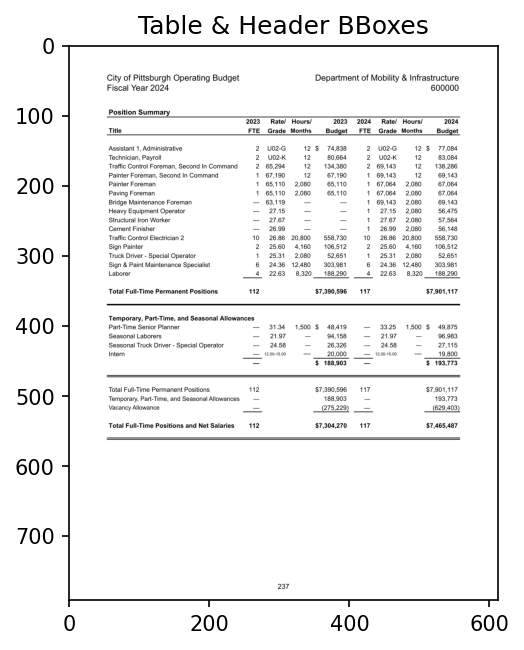

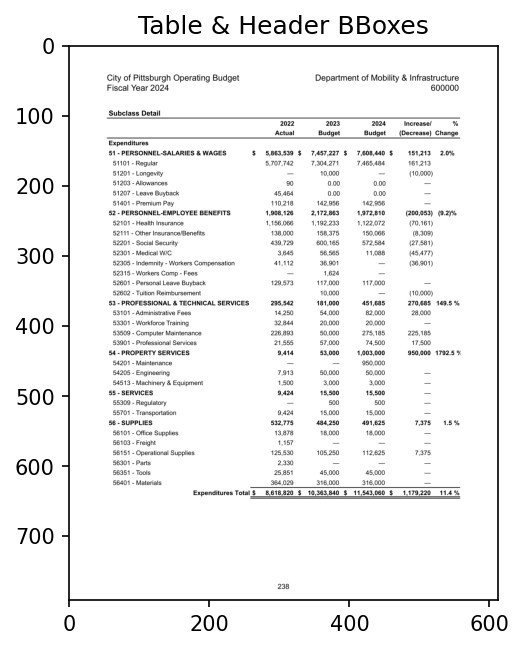

In [8]:
import time
df_list = []
for j in range(237,239):
    page = doc[j]
    tabs = page.find_tables()  # detect the tables
    for i,tab in enumerate(tabs):  # iterate over all tables
        df = tab.to_pandas()
        df_list.append(df)
        for cell in tab.header.cells:
            page.draw_rect(cell,color=fitz.pdfcolor["red"],width=0.3)
        page.draw_rect(tab.bbox,color=fitz.pdfcolor["green"])
        print(f"Page {j+1}, Table {i} column names: {tab.header.names}, external: {tab.header.external}")
        
    show_image(page, f"Table & Header BBoxes")

## 2024 Operating Budget


In [ ]:
# https://apps.pittsburghpa.gov/redtail/images/23255_2024_Operating_Budget.pdf

In [3]:
pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 23.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import camelot
pdf_url = 'https://apps.pittsburghpa.gov/redtail/images/23255_2024_Operating_Budget.pdf'
pdf_response = requests.get(pdf_url)
with open('2024OperatingBudge.pdf', 'wb') as file:
    file.write(pdf_response.content)


In [2]:
tables = camelot.read_pdf('2024OperatingBudge.pdf')

/opt/anaconda3/envs/crawl/lib/python3.12/site-packages/camelot/parsers/lattice.py:411: UserWarning: page-1 is image-based, camelot only works on text-based pages.
  warnings.warn(


In [3]:
len(tables)

0

In [1]:
pip install tabula-py

Note: you may need to restart the kernel to use updated packages.


In [ ]:
with open('2024OperatingBudge.pdf', 'wb') as file:
    file.write(pdf_response.content)

## CMU about

In [ ]:
# https://www.cmu.edu/about/
# div class_ = 'content'
# 找link 从：nav id = 'nav'；div class_ = 'sidebar'

In [12]:
import requests
from bs4 import BeautifulSoup
import json
import time
from urllib.parse import urljoin

# 初始化全局变量，用来存储已访问过的URL和最终的内容
visited = set()
content_data = {}

# 获取页面内容并解析
def get_page_content(url):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            return BeautifulSoup(response.text, 'html.parser')
        else:
            print(f"Failed to retrieve page: {url}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Error retrieving page {url}: {e}")
        return None


# 递归爬取链接
def recursive_crawl(url, base_url, depth):
    if 'cmu.edu' not in url:
        return
    # 如果深度超过2，则停止递归
    if depth > 2:
        return
    if url.endswith('.pdf'):
        print(f"Depth: {depth} | Skipping PDF file: {url}")
        return
    
    if url in visited:
        return
    
    print(f"Depth: {depth} | Visiting: {url} ")
    visited.add(url)
    
    soup = get_page_content(url)
    if soup is None:
        return
    
    
    # 提取主要内容
    passage = soup.find('div', class_='content')
    if passage is None or len(passage.get_text(strip=True)) < 1:
        passage = soup.find('div', id='content')
    if passage is None or len(passage.get_text(strip=True)) < 1:
        passage = soup.find('div', id = "block-mainpagecontent")
    if passage is None or len(passage.get_text(strip=True)) < 1:
        passage = soup.find('main', class_='main')
    if passage is None or len(passage.get_text(strip=True)) < 1:
        return
        
    passage_text, head_name = parse_content_with_hierarchy0(passage)
    if head_name is None:
        head_name = url
    if passage_text:
        content_data[head_name] = passage_text
    
    if depth >= 2:
        return

    # 寻找页面中的nav和sidebar中的链接
    nav_links = soup.find('nav', id='nav')
    sidebar_links = soup.find('div', class_='sidebar')
    
    links = set()
    if nav_links:
        links.update([a['href'] for a in nav_links.find_all('a', href=True)])
    if sidebar_links:
        links.update([a['href'] for a in sidebar_links.find_all('a', href=True)])
    if passage:
        links.update([a['href'] for a in passage.find_all('a', href=True)])
    print(f"Depth: {depth} | Found {len(links)} links on {url}  ")
    
    # 递归爬取每个找到的链接，深度加1
    for link in links:
        full_link = urljoin(base_url, link)
        if full_link not in visited:
            # time.sleep(1)  # 避免过于频繁的请求
            recursive_crawl(full_link, base_url, depth + 1)


In [61]:
content_data

{'The Future': {'Andrew Carnegie': {'content': ['A self-educated "working boy" who loved books, Andrew Carnegie emigrated from Scotland in 1848 and settled in Pittsburgh, Pa. Attending night school and borrowing books, Carnegie went from factory worker in a textile mill to successful entrepreneur and industrialist. He rose to prominence by founding what became the world\'s largest steel producing company by the end of the 19th century.']},
  'Carnegie Technical Schools': {'content': ['At one point the richest man in the world, Carnegie believed that "to die rich is to die disgraced." He turned his attention to writing, social activism and philanthropy, determined to establish educational opportunities for the general public where few existed.',
    'In 1900, he donated $1 million for the creation of a technical institute for the city of Pittsburgh, envisioning a school where working-class men and women of Pittsburgh could learn practical skills, trades and crafts that would enhance the

In [60]:
# 主函数
def main():
    urls = ['https://www.cmu.edu/about/history.html', 'https://www.cmu.edu/about/', 'https://www.cmu.edu/academics/index.html',
    'https://www.cmu.edu/engage/alumni/','https://www.cmu.edu/student-experience/index.html']
    for i in range(len(urls)):
        recursive_crawl(urls[i], urls[i], 0)

    # 将爬取的结果保存为JSON文件
    with open('cmu_about_content1.json', 'w', encoding='utf-8') as f:
        json.dump(content_data, f, ensure_ascii=False, indent=4)

    print(f"Data saved to cmu_about_content.json")

if __name__ == "__main__":
    main()

Depth: 0 | Visiting: https://www.cmu.edu/about/history.html 
{'Andrew Carnegie': {'content': ['A self-educated "working boy" who loved books, Andrew Carnegie emigrated from Scotland in 1848 and settled in Pittsburgh, Pa. Attending night school and borrowing books, Carnegie went from factory worker in a textile mill to successful entrepreneur and industrialist. He rose to prominence by founding what became the world\'s largest steel producing company by the end of the 19th century.']}, 'Carnegie Technical Schools': {'content': ['At one point the richest man in the world, Carnegie believed that "to die rich is to die disgraced." He turned his attention to writing, social activism and philanthropy, determined to establish educational opportunities for the general public where few existed.', 'In 1900, he donated $1 million for the creation of a technical institute for the city of Pittsburgh, envisioning a school where working-class men and women of Pittsburgh could learn practical skills, 

In [62]:
def retrieve_url(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    return soup

In [66]:
def parse_page_nature(url):
    """
    Parse a single New York Times article at the given URL
    
    args:
        url (str) : the article URL
    
    return:
        Dict[str, str] : the parsed information stored in JSON format, which includes:
            Title, Author, Published Date, Summary and Content
    """
    soup = retrieve_url(url)

    title = soup.find('meta', attrs={'name':"dc.title"})['content']
    authors_raw = soup.find_all('meta', attrs={'name': 'dc.creator'})
    authors = []
    for meta in authors_raw:
      authors.append(meta['content'])
      
    published_date = soup.find('meta', attrs={'name':"prism.publicationDate"})['content']
    summary = soup.find('meta', attrs={'name':"description"})['content']

    article_body = soup.find('div', class_='article__body serif cleared')
    if article_body is None:
      article_body = soup.find('div', class_='article__body cleared')
      
    print(article_body.find_all('p', recursive=False))
    if article_body:
        content = [p.get_text() for p in article_body.find_all('p', recursive=False)]
    

In [67]:
parse_page_nature("http://web.archive.org/web/20210308142952/https://www.nature.com/articles/d41586-020-00166-6")

[<p>The world is racing to learn more about the <a data-label="https://www.nature.com/articles/d41586-020-00154-w" data-track="click" data-track-category="body text link" href="http://web.archive.org/web/20210308142952/https://www.nature.com/articles/d41586-020-00154-w">outbreak of a new viral infection</a> that was first detected in Wuhan, China, last month and is causing increasing alarm around the world.</p>, <p>As <i>Nature</i> went to press, officials in China had confirmed more than 4,500 cases of the virus, which causes a respiratory illness, and some 100 deaths. Around 50 cases had also been confirmed in other countries, in Asia, the United States and Europe.</p>, <p>
<aside class="recommended pull pull--left sans-serif" data-label="Related">
<a data-track="click" data-track-label="recommended article" href="http://web.archive.org/web/20210308142952/https://www.nature.com/articles/d41586-020-00154-w"><img alt="" class="recommended__image" src="//web.archive.org/web/202103081429